<a href="https://colab.research.google.com/github/Amonye/Amonye/blob/main/Student%20Success/Failure%20Prediction%20using%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer



In [27]:
#In order to import the data, we need to load it onto our notebook
#  Load the dataset into a Pandas DataFrame

In [28]:
# Step 1: Load datasets (example CSV file paths)
students_df = pd.read_csv('/content/Tables  - Students Data.csv') #Student record
grades_df = pd.read_csv('/content/Tables  - grades.csv')  # Academic history and last exam scores
attendance_df = pd.read_csv('/content/Tables  - Attendance_data.csv')  # Attendance data
extra_curricular_df = pd.read_csv('/content/Tables  - Extracurricular activities.csv')  # Extracurricular data
parent_data_df = pd.read_csv('/content/Tables  - Parent Data.csv')  # Socioeconomic and family involvement data



In [29]:
students_df.drop(['date_of_birth','street_address', 'date_enrolled'], axis=1, inplace=True)

In [30]:
# Step 2: Merge datasets on a unique identifier (student_id)
merged_df = grades_df.merge(attendance_df, on='student_id', how='left') \
                     .merge(extra_curricular_df, on='student_id', how='left') \
                     .merge(students_df, on = 'student_id', how='left')




In [31]:
merged_df1 = pd.merge(parent_data_df, students_df, on='parent_id', how='left')


In [32]:
merged_df2 = pd.merge(merged_df, merged_df1, on='parent_id', how='left')

In [15]:
merged_df2.drop(['parent_id','student_id_x','subject_id','attendance_id','class_id_x','class_id_y','student_id_y','activity_id', 'grade_id'], axis=1, inplace=True)

In [33]:
merged_df2.shape

(10182120, 39)

In [34]:
# We reduce sample size and work with top valid rows due to extra rows at the bottom

# Get the total number of rows in the DataFrame
total_rows = len(merged_df2)

# Drop the bottom 500,000 rows using iloc
merged_df2 = merged_df2.iloc[:total_rows - 9000000]


In [35]:
merged_df2.shape

(1182120, 39)

array([[<Axes: title={'center': 'grade_id'}>,
        <Axes: title={'center': 'student_id_x'}>,
        <Axes: title={'center': 'subject_id'}>,
        <Axes: title={'center': 'first_test'}>],
       [<Axes: title={'center': 'second_test'}>,
        <Axes: title={'center': 'exam'}>,
        <Axes: title={'center': 'total_score'}>,
        <Axes: title={'center': 'academic_year'}>],
       [<Axes: title={'center': 'attendance_id'}>,
        <Axes: title={'center': 'activity_id'}>,
        <Axes: title={'center': 'hours_spent'}>,
        <Axes: title={'center': 'parent_id'}>],
       [<Axes: title={'center': 'class_id_x'}>,
        <Axes: title={'center': 'age_x'}>,
        <Axes: title={'center': 'student_id_y'}>,
        <Axes: title={'center': 'class_id_y'}>],
       [<Axes: title={'center': 'age_y'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

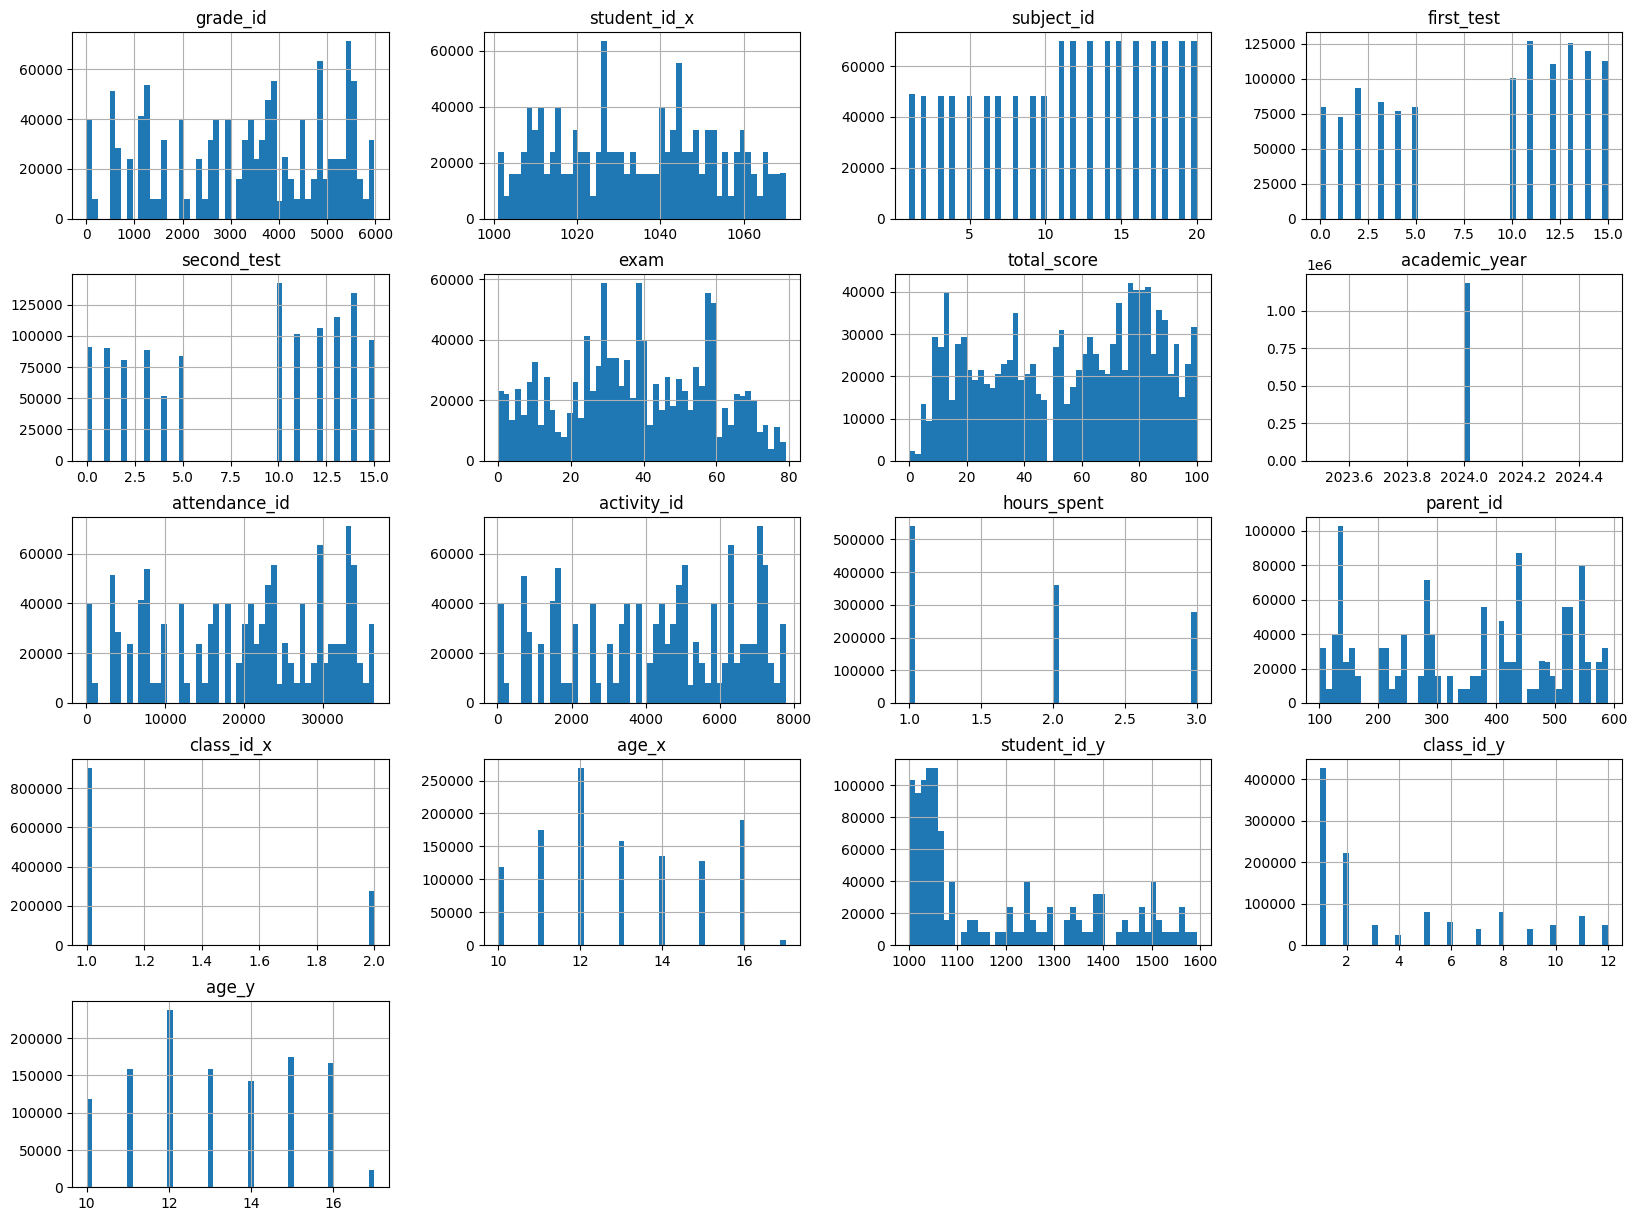

In [36]:
#Visualisation of variables in our data for evaluation
merged_df2.hist(bins=50, figsize=(20,15))

<Axes: ylabel='count'>

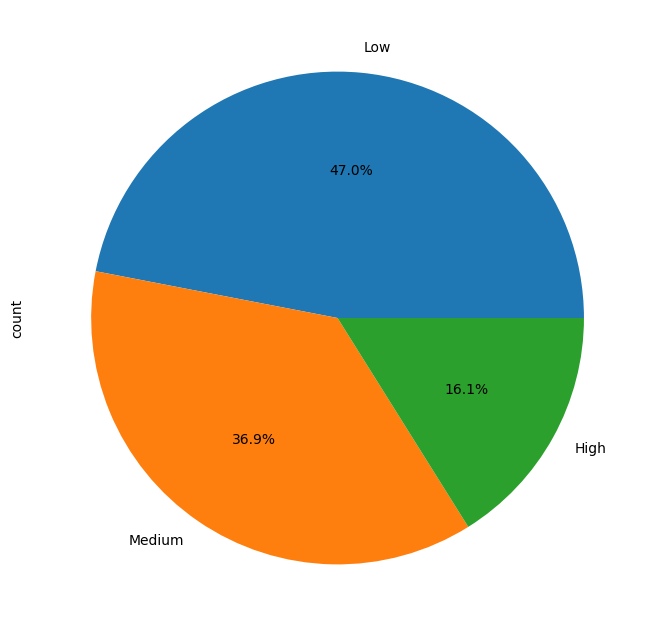

In [37]:
# Pie chart for income_bracket showing that there are more low and medium income earners in the school than the high income earners
merged_df2['income_bracket'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))


In [39]:
#statistical summary of data set
merged_df2.shape

(1182120, 39)

In [40]:
# Step 1: Map 'Present' and 'Absent' to 1 and 0, and ignore NaN
merged_df2['attendance_numeric'] = merged_df2['status'].map({'Present': 1, 'Absent': 0})

# Step 2: Drop rows where 'attendance_numeric' is NaN
cleaned_df = merged_df2.dropna(subset=['attendance_numeric'])

# Step 3: Calculate attendance rate as a percentage
attendance_rate = cleaned_df['attendance_numeric'].mean() * 100

#This shows the attendance rate based on the variability in income level
print("Attendance Rate: {:.2f}%".format(attendance_rate))


Attendance Rate: 81.03%


In [41]:
# Moving onto other variables. we create a binary column for extracurricular involvement (1 for Yes, 0 for No)
merged_df2['extracurricular_involvement'] = merged_df2['hours_spent'].apply(lambda x: 1 if x == 'Yes' else 0)

In [42]:
#This is to re-check if there are still any Null value that may affect our analysis
merged_df2.isna().sum()

,0
grade_id,0
student_id_x,0
subject_id,0
first_test,0
second_test,0
exam,0
total_score,0
grade,0
academic_year,0
term,0


Now that the Null values are clear, we use a simple inputer to  cover any gaps using the statistics (mean, median or most frequent) of each column in which the missing values are located

In [45]:
from sklearn.impute import SimpleImputer

# Step 1: Convert 'Present' and 'Absent' in 'status' column to numeric values
merged_df2['status'] = merged_df2['status'].map({'Present': 1, 'Absent': 0})

# Step 2: Handle missing values (if any)

# Separate columns based on data type
numeric_columns = merged_df2.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = merged_df2.select_dtypes(include=['object']).columns

# Filter out columns with all NaN values for numeric columns
numeric_columns_to_impute = [col for col in numeric_columns if merged_df2[col].notna().any()]

# Filter out columns with object type for numeric columns
numeric_columns_to_impute = [col for col in numeric_columns_to_impute if merged_df2[col].dtype != 'object']

# Impute missing values for filtered numeric columns using 'median'
numeric_imputer = SimpleImputer(strategy='median')
merged_df2[numeric_columns_to_impute] = numeric_imputer.fit_transform(merged_df2[numeric_columns_to_impute])

# Impute missing values for categorical columns using 'most_frequent'
categorical_imputer = SimpleImputer(strategy='most_frequent')
merged_df2[categorical_columns] = categorical_imputer.fit_transform(merged_df2[categorical_columns])

In [48]:
# Step 5: Define the target variable (pass/fail based on the last term score)
# Let's assume 'last_exam_score' is available, with pass as >= 50
merged_df2['pass_fail'] = merged_df2['total_score'].apply(lambda x: 1 if x >= 50 else 0)



Having sorted our data. we can then start building our machine learning model

In [49]:
# Step 6: Prepare features (X) and target (y)
# Selecting key factors affecting exam outcome (excluding previous exam records but including current exam)
X = merged_df2[['status', 'hours_spent', 'income_bracket', 'extracurricular_involvement']]  # Add other factors as needed
y = merged_df2['pass_fail']



In [50]:
# Step 7: Train-Test Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [51]:
print(X_train.columns)

Index(['status', 'hours_spent', 'income_bracket',
       'extracurricular_involvement'],
      dtype='object')


In [52]:
print(X_test.columns)

Index(['status', 'hours_spent', 'income_bracket',
       'extracurricular_involvement'],
      dtype='object')


In [54]:
# Step 8: Build the RandomForestClassifier model
# Convert 'status' column to numerical representation using one-hot encoding
from sklearn.ensemble import RandomForestClassifier
import pandas as pd # Make sure pandas is imported

# Create dummies only for the original categorical columns
X_train = pd.get_dummies(X_train, columns=['status', 'income_bracket', 'extracurricular_involvement'])
# hours_spent is likely already numerical


# Now fit the model with the transformed data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 1: Perform one-hot encoding before train-test split
# Make sure you have same columns for encoding in both train and test sets
columns_to_encode = ['status', 'hours_spent', 'extracurricular_involvement', 'income_bracket']
X_encoded = pd.get_dummies(X, columns=columns_to_encode)

# Step 2: Train-Test Split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 3: Build the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate
y_pred = model.predict(X_test)

In [56]:
# Step 9: Make predictions and evaluate

y_pred = model.predict(X_test)

In [57]:
# Step 10: Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.5882693804351504


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     97343
           1       0.59      1.00      0.74    139081

    accuracy                           0.59    236424
   macro avg       0.29      0.50      0.37    236424
weighted avg       0.35      0.59      0.44    236424

Confusion Matrix:
 [[     0  97343]
 [     0 139081]]


Precision = 0.59:

This means 59% of the predictions for "pass" are correct.

Recall = 1.00: The recall is 100%, meaning all students who passed were correctly identified.

In [58]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,  # Use X_encoded.columns instead of X.columns
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance)

Feature Importance:
                            Feature  Importance
6            income_bracket_Medium    0.577380
5               income_bracket_Low    0.235465
4              income_bracket_High    0.119434
1                  hours_spent_2.0    0.031684
0                  hours_spent_1.0    0.021311
2                  hours_spent_3.0    0.014726
3  extracurricular_involvement_0.0    0.000000


Explanation:


income_bracket_Medium (0.577): This is the most important feature in the model. It contributes the most to the prediction of whether a student will pass or fail. Students in the "Medium" income bracket seem to have a strong impact on the outcome.

income_bracket_Low (0.235): Students in the "Low" income bracket also have a significant impact on the prediction but less than those in the "Medium" bracket.

income_bracket_High (0.119): The "High" income bracket has a lesser but still notable influence compared to "Medium" and "Low" brackets.

hours_spent features (2.0, 1.0, 3.0): Time spent on studying or coursework has less of an influence on the outcome compared to income bracket, but it still matters.

extracurricular_involvement_0.0 (0.000): The model found no influence of extracurricular involvement in predicting whether a student passes or fails, as indicated by the zero importance score